In [2]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re, nltk, gensim, spacy
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer,  TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text 
from sklearn.metrics import pairwise_distances
from gensim import corpora, models, similarities, matutils
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
#open file and take a look at features

df_jobs = pd.read_csv("/Users/Daniel/Desktop/Combined_Jobs_Final.csv")
df_jobs.head()

,Job.ID,Provider,Status,Slug,Title,Position,Company,City,State.Name,State.Code,...,Industry,Job.Description,Requirements,Salary,Listing.Start,Listing.End,Employment.Type,Education.Required,Created.At,Updated.At
0,111,1,open,palo-alto-ca-tacolicious-server,Server @ Tacolicious,Server,Tacolicious,Palo Alto,California,CA,...,Food and Beverages,Tacolicious' first Palo Alto store just opened...,NaN,8.00,NaN,NaN,Part-Time,NaN,2013-03-12 02:08:28 UTC,2014-08-16 15:35:36 UTC
1,113,1,open,san-francisco-ca-claude-lane-kitchen-staff-chef,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,California,CA,...,Food and Beverages,\r\n\r\nNew French Brasserie in S.F. Financia...,NaN,0.00,NaN,NaN,Part-Time,NaN,2013-04-12 08:36:36 UTC,2014-08-16 15:35:36 UTC
2,117,1,open,san-francisco-ca-machka-restaurants-corp-barte...,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,California,CA,...,Food and Beverages,We are a popular Mediterranean wine bar and re...,NaN,11.00,NaN,NaN,Part-Time,NaN,2013-07-16 09:34:10 UTC,2014-08-16 15:35:37 UTC
3,121,1,open,brisbane-ca-teriyaki-house-server,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,California,CA,...,Food and Beverages,● Serve food/drinks to customers in a profess...,NaN,10.55,NaN,NaN,Part-Time,NaN,2013-09-04 15:40:30 UTC,2014-08-16 15:35:38 UTC
4,127,1,open,los-angeles-ca-rosa-mexicano-sunset-kitchen-st...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,California,CA,...,Food and Beverages,"Located at the heart of Hollywood, we are one ...",NaN,10.55,NaN,NaN,Part-Time,NaN,2013-07-17 15:26:18 UTC,2014-08-16 15:35:40 UTC


In [4]:
df_jobs.loc[0,'Job.Description']

"Tacolicious' first Palo Alto store just opened recently, and we are hiring! If you love tacos, you will love working at our restaurant! \r\n\r\n ● Serve food/drinks to customers in a professional manner \r\n ● Act as a cashier when needed \r\n ● Clean up the dining space \r\n ● Train the new staff \r\n"

In [5]:
# quick look at the types of data 
df_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84090 entries, 0 to 84089
Data columns (total 23 columns):
Job.ID                84090 non-null int64
Provider              84090 non-null int64
Status                84090 non-null object
Slug                  84090 non-null object
Title                 84090 non-null object
Position              84090 non-null object
Company               81819 non-null object
City                  83955 non-null object
State.Name            83919 non-null object
State.Code            83919 non-null object
Address               36 non-null object
Latitude              84090 non-null float64
Longitude             84090 non-null float64
Industry              267 non-null object
Job.Description       84034 non-null object
Requirements          0 non-null float64
Salary                229 non-null float64
Listing.Start         83407 non-null object
Listing.End           83923 non-null object
Employment.Type       84080 non-null object
Education.Required  

In [6]:
# check for null values

df_jobs.isnull().sum()

Job.ID                    0
Provider                  0
Status                    0
Slug                      0
Title                     0
Position                  0
Company                2271
City                    135
State.Name              171
State.Code              171
Address               84054
Latitude                  0
Longitude                 0
Industry              83823
Job.Description          56
Requirements          84090
Salary                83861
Listing.Start           683
Listing.End             167
Employment.Type          10
Education.Required      267
Created.At                0
Updated.At                0
dtype: int64

In [7]:
# Take columns that are relavent

cols = ['Job.ID']+['Title']+['Position']+ ['Company']+['Employment.Type']+['Job.Description']
df_jobs =df_jobs[cols]
df_jobs.columns = ['Job.ID', 'Title', 'Position', 'Company', 'Empl_type','Job_Description']
df_jobs.head()

,Job.ID,Title,Position,Company,Empl_type,Job_Description
0,111,Server @ Tacolicious,Server,Tacolicious,Part-Time,Tacolicious' first Palo Alto store just opened...
1,113,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,Part-Time,\r\n\r\nNew French Brasserie in S.F. Financia...
2,117,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,Part-Time,We are a popular Mediterranean wine bar and re...
3,121,Server @ Teriyaki House,Server,Teriyaki House,Part-Time,● Serve food/drinks to customers in a profess...
4,127,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Part-Time,"Located at the heart of Hollywood, we are one ..."


In [8]:
#Check for nulls again 

df_jobs.isnull().sum()

Job.ID                0
Title                 0
Position              0
Company            2271
Empl_type            10
Job_Description      56
dtype: int64

In [9]:
# Seems like uber has all the nulls from Empl_type

df_nan_emp = df_jobs[pd.isnull(df_jobs['Empl_type'])]
df_nan_emp.head(20)

,Job.ID,Title,Position,Company,Empl_type,Job_Description
10768,153197,Driving Partner @ Uber,Driving Partner,Uber,NaN,Uber is changing the way the world moves. From...
10769,153198,Driving Partner @ Uber,Driving Partner,Uber,NaN,Uber is changing the way the world moves. From...
10770,153199,Driving Partner @ Uber,Driving Partner,Uber,NaN,Uber is changing the way the world moves. From...
10771,153200,Driving Partner @ Uber,Driving Partner,Uber,NaN,Uber is changing the way the world moves. From...
10772,153201,Driving Partner @ Uber,Driving Partner,Uber,NaN,Uber is changing the way the world moves. From...
10773,153202,Driving Partner @ Uber,Driving Partner,Uber,NaN,Uber is changing the way the world moves. From...
10774,153203,Driving Partner @ Uber,Driving Partner,Uber,NaN,Uber is changing the way the world moves. From...
10775,153204,Driving Partner @ Uber,Driving Partner,Uber,NaN,Uber is changing the way the world moves. From...
10776,153205,Driving Partner @ Uber,Driving Partner,Uber,NaN,Uber is changing the way the world moves. From...
10777,153206,Driving Partner @ Uber,Driving Partner,Uber,NaN,Uber is changing the way the world moves. From...


In [10]:
# check the types of employment

df_jobs['Empl_type'].unique()

array(['Part-Time', 'Full-Time/Part-Time', 'Seasonal/Temp', 'Per Diem',
       'Intern', nan, 'Full-Time', 'Contract', 'Temporary/seasonal'],
      dtype=object)

In [11]:
# Fill in the NaN with Full-time/Part-time

df_jobs['Empl_type']=df_jobs['Empl_type'].fillna('Full-Time/Part-Time')
df_jobs.groupby(['Empl_type'])['Company'].count()
df_jobs.head()

,Job.ID,Title,Position,Company,Empl_type,Job_Description
0,111,Server @ Tacolicious,Server,Tacolicious,Part-Time,Tacolicious' first Palo Alto store just opened...
1,113,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,Part-Time,\r\n\r\nNew French Brasserie in S.F. Financia...
2,117,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,Part-Time,We are a popular Mediterranean wine bar and re...
3,121,Server @ Teriyaki House,Server,Teriyaki House,Part-Time,● Serve food/drinks to customers in a profess...
4,127,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Part-Time,"Located at the heart of Hollywood, we are one ..."


In [12]:
# Combine the company employ_type and job_description together to make our text

df_jobs["text"] = df_jobs["Position"].map(str) + " " + df_jobs["Company"] +" "+df_jobs['Empl_type']+" "+df_jobs['Job_Description'] +" "+df_jobs['Title']
df_jobs.head(5)

,Job.ID,Title,Position,Company,Empl_type,Job_Description,text
0,111,Server @ Tacolicious,Server,Tacolicious,Part-Time,Tacolicious' first Palo Alto store just opened...,Server Tacolicious Part-Time Tacolicious' firs...
1,113,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,Part-Time,\r\n\r\nNew French Brasserie in S.F. Financia...,Kitchen Staff/Chef Claude Lane Part-Time \r\n...
2,117,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,Part-Time,We are a popular Mediterranean wine bar and re...,Bartender Machka Restaurants Corp. Part-Time W...
3,121,Server @ Teriyaki House,Server,Teriyaki House,Part-Time,● Serve food/drinks to customers in a profess...,Server Teriyaki House Part-Time ● Serve food/...
4,127,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Part-Time,"Located at the heart of Hollywood, we are one ...",Kitchen Staff/Chef Rosa Mexicano - Sunset Part...


In [13]:
#This is the final dataframe we will work with

df_all = df_jobs[['Job.ID', 'text', 'Title']]
df_all = df_all.fillna(" ")
df_all.head()

,Job.ID,text,Title
0,111,Server Tacolicious Part-Time Tacolicious' firs...,Server @ Tacolicious
1,113,Kitchen Staff/Chef Claude Lane Part-Time \r\n...,Kitchen Staff/Chef @ Claude Lane
2,117,Bartender Machka Restaurants Corp. Part-Time W...,Bartender @ Machka Restaurants Corp.
3,121,Server Teriyaki House Part-Time ● Serve food/...,Server @ Teriyaki House
4,127,Kitchen Staff/Chef Rosa Mexicano - Sunset Part...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset


In [14]:
df_all.shape

(84090, 3)

In [15]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/Daniel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Daniel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Daniel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [16]:
# Funtion that cleans the text and lemmetizes the text. 
# Parts of cleaning text are from towardsdatascience

stop = stopwords.words('english')
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2   
  
def clean_txt(text):
    clean_text = []
    clean_text2 = []
    text = re.sub("'", "",text)
    text=re.sub("(\\d|\\W)+"," ",text) 
    text = text.replace("nbsp", "")
    clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    return " ".join(clean_text2)

In [17]:
# Apply the cleaning function to the text column

df_all['text'] = df_all['text'].apply(clean_txt)

In [18]:
# Take a look at the clean text. It seems to be clean of punctuation and is lemmetized 
df_all.head(20)

,Job.ID,text,Title
0,111,server tacolicious part time tacolicious first...,Server @ Tacolicious
1,113,kitchen staff chef claude lane part time new f...,Kitchen Staff/Chef @ Claude Lane
2,117,bartender machka restaurants corp part time po...,Bartender @ Machka Restaurants Corp.
3,121,server teriyaki house part time serve food dri...,Server @ Teriyaki House
4,127,kitchen staff chef rosa mexicano sunset part t...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset
5,129,receptionist mind beauty day spa part time gro...,Receptionist @ Mind of Beauty Day Spa
6,131,server roys woodland hill part time serve food...,Server @ Roy's Woodland Hills
7,133,driver koja kitchen part time koja kitchen par...,Driver @ KoJa Kitchen
8,134273,assistant store manager kings food market part...,Assistant Store Manager @ King's Food Markets
9,134274,store associate retail sales customer service ...,Store Associate - Retail Sales (Customer Servi...


In [19]:
# stop words to add after a few rounds of LDA 
add_stop_words = ['work', 'skill', 'requir', 'use', 'pm', 'paybl', 'abil', 'perform', 'time',
                  'provid', 'email', 'click', 'job', 'descript', 'strong','hour', 'religion',
                 'flexibl', 'schedul', 'previous', 'nbsp', 'www','apply', 'look foward', 'choice','usa',
                 'essential function', 'skills', 'sense', 'good' ,'location', 'inclusive', 'experience', 'income',
                 'make', 'available','race', 'color', 'sex','disability', 'veteran',
                 'career', 'need', 'ability', 'require']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [20]:
# Tfidf Vectorizer set to unigrams and bigrams

tf_vectorizer = TfidfVectorizer(ngram_range=(1,2), lowercase= True, stop_words=stop_words, token_pattern = "\\b[a-z][a-z]+\\b",
                                max_df = 0.8,
                               min_df = 0.01)

df_tf = tf_vectorizer.fit_transform(df_all['text'])
print(df_tf.toarray())
print(len(df_tf.toarray()))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['essential', 'foward', 'function', 'look'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.15150415 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.07048336 ... 0.         0.         0.        ]
 [0.         0.         0.08970897 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
84090


In [21]:
df_tf.shape

(84090, 2254)

In [21]:
#Count Vectorizer set to unigrams and bigrams 

vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words= 'english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.8, min_df = 0.03)
df_cv = vectorizer.fit_transform(df_all['text'])
print(df_cv.toarray())
print(len(df_cv.toarray()))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
84090


In [22]:
# doc-term matrix

df_cv.shape

(84090, 825)

## NMF - CountVectorizer

In [23]:
# Convert to document topic matrix

nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(df_cv)
doc_topic.shape

(84090, 10)

In [24]:
#topic to word matrix

topic_word = nmf_model.components_
topic_word.shape

(10, 825)

In [25]:
# Get top words for each topic
# Code from classroom notebook

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [26]:
display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
work, time, job, ability, skills, experience, require, use, include, able

Topic  1
home, care, health, home health, health care, time, clients, provide, service, opportunity

Topic  2
sales, retail, associate, store, sales associate, products, retail sales, customers, product, time

Topic  3
service, customer, customer service, bank, provide, service representative, customers, representative, time, maintain

Topic  4
sales, time, rsquo, sales representative, representative, train, time time, market, need, entry

Topic  5
account, accountemps, clerk, payable, account payable, temp, seasonal temp, classification, seasonal, ref

Topic  6
nurse, care, register, register nurse, lpn, healthcare, license, charge, time, residents

Topic  7
patient, care, patients, provide, service, plan, health, medical, appropriate, need

Topic  8
event, product, sales, market, specialist, products, area, lbs, brand, materials

Topic  9
career, train, school, service, grow, available, job, employme

## NMF - TfidfVectorizer

In [27]:
#NMF model - doc to topic matrix

nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(df_tf)
doc_topic.shape

(84090, 10)

In [28]:
#Topic to word matrix

topic_word = nmf_model.components_
topic_word.shape

(10, 2254)

In [29]:
# Display top words for each topic
# Code from classroom notebook

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [30]:
display_topics(nmf_model, tf_vectorizer.get_feature_names(), 10)


Topic  0
service, security, maintain, include, provide, duties, ensure, team, position, train

Topic  1
home, home health, bayada, care, health, health care, bayada home, aide, health aide, nurse

Topic  2
account, clerk, payable, account payable, accountemps, account clerk, clerk accountemps, payable clerk, receivable, account receivable

Topic  3
assistant, administrative, administrative assistant, assistant officeteam, officeteam, admin, office, secretary, secretary admin, classification secretary

Topic  4
sales, rsquo, sales representative, vector, vector market, entry level, train, representative, market, ndash

Topic  5
sales, retail, associate, store, sales associate, retail sales, wireless, products, target, product

Topic  6
customer, customer service, service representative, service, representative, representative officeteam, officeteam, customer servicecompensation, servicecompensation, classification customer

Topic  7
accountant, staff accountant, accountemps, staff, acc

## LSA - CountVectorizer

In [31]:
#LSA countvectorizer - document to topic matrix

lsa = TruncatedSVD(10)
doc_topic = lsa.fit_transform(df_cv)
lsa.explained_variance_ratio_

array([0.09372126, 0.09414755, 0.04161707, 0.03325437, 0.02940089,
       0.02688991, 0.02402628, 0.01813204, 0.01675869, 0.01545773])

In [32]:
# topic_word = pd.DataFrame(lsa.components_.round(3),
#              index = ["component_1","component_2", '3', '4', '5', '6', '7', '8', '9', '10'],
#              columns = vectorizer.get_feature_names())


In [33]:
# Display top words for each topic
# Code from classroom notebook

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [34]:
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
service, time, sales, work, care, customer, provide, need, include, experience

Topic  1
care, nurse, home, health, home health, patient, health care, patients, provide, medical

Topic  2
account, service, work, perform, customer, duties, process, maintain, staff, accountemps

Topic  3
service, customer, customer service, rsquo, time, representative, time time, train, career, home

Topic  4
service, customer, customer service, store, retail, patient, products, nurse, provide, bank

Topic  5
time, nurse, patient, job, rsquo, train, work, school, schedule, patients

Topic  6
nurse, account, sales, patient, rsquo, accountemps, clerk, patients, sales representative, representative

Topic  7
nurse, customer, skills, experience, work, customers, associate, ability, customer service, seasonal

Topic  8
event, nurse, product, market, specialist, lbs, area, customer, schedule, customer service

Topic  9
nurse, career, time, train, retail, store, available, service, account, grow


# LSA TfidfVectorizer

In [35]:
#LSA using Tfidf as vectorizer - doc/topic matrix

lsa = TruncatedSVD(10)
doc_topic = lsa.fit_transform(df_tf)
lsa.explained_variance_ratio_

array([0.00717017, 0.03655071, 0.03125648, 0.02216305, 0.01769916,
       0.01581159, 0.01435438, 0.01352049, 0.0123636 , 0.01049515])

In [36]:
# Display top words for each topic
# Code from classroom notebook

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [37]:
display_topics(lsa, tf_vectorizer.get_feature_names(), 10)


Topic  0
sales, service, care, customer, nurse, account, home, health, customer service, assistant

Topic  1
care, nurse, home, health, home health, bayada, health care, patient, register nurse, bayada home

Topic  2
account, clerk, accountemps, payable, account payable, nurse, care, accountant, home, health

Topic  3
assistant, officeteam, administrative, administrative assistant, assistant officeteam, office, receptionist, officeteam seasonal, admin, secretary

Topic  4
home, bayada, representative, home health, rsquo, sales representative, sales, vector, entry, customer service

Topic  5
retail, sales, bayada, home, assistant, home health, administrative assistant, administrative, associate, sales associate

Topic  6
customer, customer service, service representative, service, bayada, home, home health, representative officeteam, representative, bayada home

Topic  7
accountant, staff accountant, staff, accountant accountemps, accountemps, classification accountant, senior, home, s

## LSA - Genism (!!WARNING!! this will take very long to run...like overnight)

In [38]:
# df2 = df_job
# df2

In [39]:
##split words into individual strings

# df2['text'] = df2['text'].map(lambda x: x.split(' '))

In [40]:
##Create dictionary

# dictionary = corpora.Dictionary(df2['text'])

In [41]:
## Create BoW from the dictionary

# df2['bow'] = df2['text'].map(dictionary.doc2bow)


In [42]:
# doc_term_matrix = df2['bow']

In [43]:
# doc_term_matrix

In [44]:
##compute coherence value to determine the best number of topics to run in model

# coherence_values = []
# model_list = []
# def compute_coherence_values(dictionary, doc_term_m, text, stop, start, step):
    
#     for num_topics in range(start, stop, step):
#         model = LsiModel(doc_term_m, num_topics=num_topics, id2word = dictionary)
#         model_list.append(model)
#         coherencemodel = CoherenceModel(model = model, texts = text, dictionary = dictionary, coherence='c_v')
#         coherence_values.append(coherencemodel.get_coherence())
#     return model_list, coherence_values

In [45]:
# compute_coherence_values(dictionary, doc_term_matrix, df2['text'], 12, 1, 1)

In [46]:
# # def plot_lsa(text, start, stop, step):
# # #     dictionary, doc_term_matrix = prepare_corpus(text)
# #     model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, text, stop, start, step)
    
# x = range(2, 12, 1)
# plt.plot(x, coherence_values)
# plt.xlabel("Number of Topics")
# plt.ylabel("Coherence Score")
# plt.legend(("coherence_values"), loc = 'best')
# plt.show()

In [47]:
# start, stop, step = 2, 12, 1
# plot_lsa(df_cv, start, stop, step)

In [48]:
# df2 = df_all
# df2

In [49]:
# #split words into individual strings

# df2['text'] = df2['text'].map(lambda x: x.split(' '))

In [50]:
# #Create dictionary

# id2word = corpora.Dictionary(df2['text'])



In [51]:
# # Create BoW from the dictionary

# df2['bow'] = df2['text'].map(id2word.doc2bow)
# doc_term_matrix = df2['bow']

In [52]:
# lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix,
#                                            id2word=id2word,
#                                            num_topics=4, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=10,
#                                            passes=10,
#                                            alpha='symmetric',
#                                            iterations=100,
#                                            per_word_topics=True)

## LDA - TfidfVectorizer -Gensim

In [53]:
# LDA model using tfidf vectorizer - doc/word matrix
doc_word = df_tf.transpose()

In [54]:
doc_word

<2254x84090 sparse matrix of type '<class 'numpy.float64'>'
	with 7226227 stored elements in Compressed Sparse Column format>

In [55]:
#create corpus for gensim to use

corpus = matutils.Sparse2Corpus(doc_word)

In [56]:
corpus

In [57]:
#create id2word dictionary

id2word = dict((v, k) for k, v in tf_vectorizer.vocabulary_.items())

In [58]:
len(id2word)

2254

In [59]:
lda = models.LdaModel(corpus=corpus, num_topics=10, id2word=id2word, passes=5)

In [60]:
lda.print_topics()

[(0,
  '0.088*"server" + 0.053*"restaurant" + 0.052*"food" + 0.044*"din" + 0.042*"cashier" + 0.041*"space" + 0.039*"train new" + 0.036*"professional manner" + 0.031*"cook" + 0.028*"act"'),
 (1,
  '0.052*"sales" + 0.033*"associate" + 0.027*"sales associate" + 0.023*"retail" + 0.022*"beauty" + 0.021*"store" + 0.017*"retail sales" + 0.015*"sell" + 0.015*"customers" + 0.013*"style"'),
 (2,
  '0.017*"care" + 0.017*"nurse" + 0.011*"health" + 0.010*"patient" + 0.007*"patients" + 0.007*"medical" + 0.006*"center" + 0.006*"provide" + 0.006*"service" + 0.005*"register nurse"'),
 (3,
  '0.024*"sales" + 0.019*"sales representative" + 0.012*"wireless" + 0.011*"rsquo" + 0.011*"representative" + 0.009*"vector" + 0.009*"vector market" + 0.009*"retail" + 0.009*"target" + 0.008*"sales associate"'),
 (4,
  '0.035*"home" + 0.027*"bayada" + 0.023*"security" + 0.023*"home health" + 0.022*"care" + 0.017*"caregiver" + 0.016*"health" + 0.015*"health care" + 0.015*"bayada home" + 0.015*"officer"'),
 (5,
  '0.009

# LDA - sklearn

In [61]:
#set up LDA model

lda_model = LatentDirichletAllocation(n_components=7, 
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  
                                     )

In [62]:
#fit and trasnform the vectorized text

lda_output = lda_model.fit_transform(df_tf)

In [63]:
# lda_output

In [64]:
# Visualize topics 

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, df_tf, tf_vectorizer, mds='tsne')

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4       46.259563   47.837471       1        1  37.041289
5       65.824646 -141.429749       2        1  19.601828
6        1.405333  -52.444111       3        1  14.651635
3      -63.013924   36.541538       4        1   9.508327
2      110.678833  -41.148174       5        1   8.784171
0     -107.868248  -63.739971       6        1   5.263849
1      -43.448906 -152.725601       7        1   5.148900, topic_info=     Category         Freq      Term        Total  loglift  logprob
1332  Default  2860.000000     nurse  2860.000000  30.0000  30.0000
263   Default  3342.000000      care  3342.000000  29.0000  29.0000
933   Default  2300.000000      home  2300.000000  28.0000  28.0000
17    Default  2702.000000   account  2702.000000  27.0000  27.0000
1825  Default  3569.000000     sales  3569.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
817    Topic7   144.251434     focus   549.522582   1.6289  -5.3401
485    Topic7   165.116373  customer  2831.324906   0.1245  -5.2050
1854   Topic7   148.143226    school   865.050056   1.2018  -5.3134
1891   Topic7   165.604295   service  3524.595788  -0.0915  -5.2020
1315   Topic7   150.006065       new  1122.580217   0.9537  -5.3010

[463 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2         1  0.345147        able
2         2  0.112722        able
2         3  0.104741        able
2         4  0.111724        able
2         5  0.000998        able
...     ...       ...         ...
2236      3  0.230866        word
2236      4  0.622858        word
2237      2  0.022692  word excel
2237      3  0.192881  word excel
2237      4  0.777196  word excel

[954 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 7, 4, 3, 1, 2])

In [65]:
#KMeans Clustering for visualization

In [66]:
from sklearn.cluster import KMeans

In [67]:
clusters = KMeans(n_clusters=7, random_state=42).fit_predict(lda_output)

In [68]:
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  
lda_output_svd = svd_model.fit_transform(lda_output)


In [69]:
# X and Y axes of the plot using SVD decomposition
#code from machinelearning plus

x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

Text(0.5, 1.0, 'Segregation of Topic Clusters')

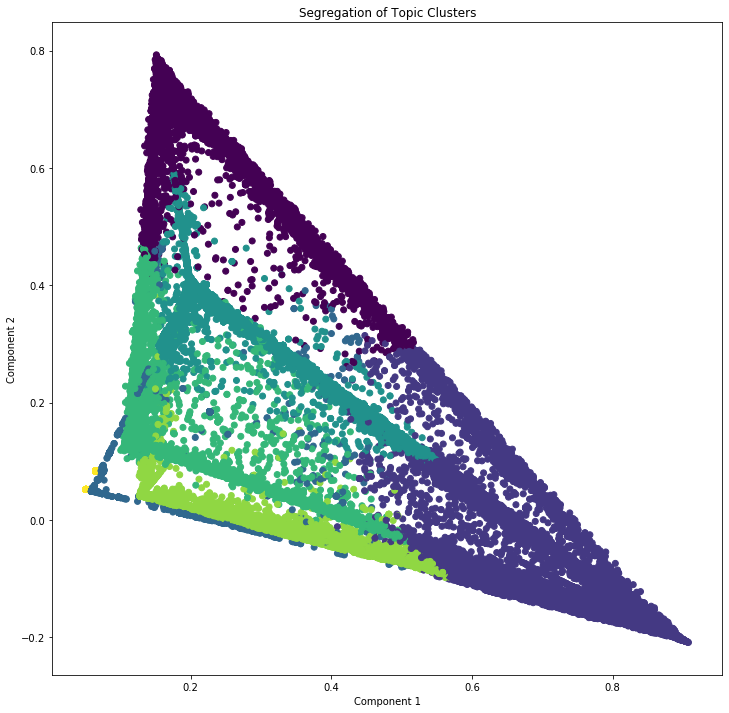

In [70]:
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [71]:
# show topics from LDA model and the most important 20 words for it. 

def show_topics(vectorizer=tf_vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(tf_vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=lda_model, n_words=20)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,macys,park,beauty,able,sales,function,essential function,retail,description,essential,customers,customer,macy,shop,vision,addition,qualifications,environment,employer commit,commit diverse
Topic 1,sales,rsquo,sales representative,entry level,vector,vector market,representative,entry,ndash,train,market,level,extra,base,opportunities,customer service,level sales,feel,schedule,service
Topic 2,nurse,care,home,health,home health,bayada,register nurse,health care,register,lpn,cna,bayada home,caregiver,patients,patient,certify,certify nurse,aide,healthcare,nurse assistant
Topic 3,officeteam,assistant,administrative,receptionist,administrative assistant,office,assistant officeteam,officeteam seasonal,temp,classification,ref,ref classification,temp ref,seasonal temp,seasonal,desk,coordinator,admin,file,secretary
Topic 4,service,care,center,provide,patient,health,medical,maintain,position,include,program,security,train,assist,staff,duties,ensure,plan,school,assign
Topic 5,sales,retail,store,customer,service,associate,customers,products,market,bull,product,customer service,sales associate,merchandise,retail sales,team,brand,wireless,sell,position
Topic 6,account,accountemps,clerk,accountant,payable,account payable,temp,classification,temp ref,ref classification,ref,accountemps seasonal,payroll,seasonal temp,seasonal,bookkeeper,data,entry,customer,specialist


In [72]:
# # 1. Wordcloud of Top N words in each topic
# from matplotlib import pyplot as plt
# from wordcloud import WordCloud, STOPWORDS
# import matplotlib.colors as mcolors

# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

# cloud = WordCloud(stopwords=stop_words,
#                   background_color='white',
#                   width=2500,
#                   height=1800,
#                   max_words=10,
#                   colormap='tab10',
#                   color_func=lambda *args, **kwargs: cols[i],
#                   prefer_horizontal=1.0)
# tf_feature_names = tf_vectorizer.get_feature_names()

# topics = lda_model.show_topics

# fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

# for i, ax in enumerate(axes.flatten()):
#     fig.add_subplot(ax)
#     topic_words = dict(topics[i][1])
#     cloud.generate_from_frequencies(topic_words, max_font_size=300)
#     plt.gca().imshow(cloud)
#     plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
#     plt.gca().axis('off')


# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
# plt.margins(x=0, y=0)
# plt.tight_layout()
# plt.show()

In [73]:
# give the topics themes

topic_theme = ['Beauty Products/Retail', 'Sales Representative/Product Support', 'Nurse/Patient Care/Health Care', 'Administrative/Office/Receptionist',
               'Security/Product Maintenance', 'Sales/Customer Services', 'Accountant/Financial/Bookkeeper']

In [74]:
df_topic_keywords['topic_theme'] = topic_theme

In [75]:
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,...,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,topic_theme
Topic 0,macys,park,beauty,able,sales,function,essential function,retail,description,essential,...,customer,macy,shop,vision,addition,qualifications,environment,employer commit,commit diverse,Beauty Products/Retail
Topic 1,sales,rsquo,sales representative,entry level,vector,vector market,representative,entry,ndash,train,...,level,extra,base,opportunities,customer service,level sales,feel,schedule,service,Sales Representative/Product Support
Topic 2,nurse,care,home,health,home health,bayada,register nurse,health care,register,lpn,...,bayada home,caregiver,patients,patient,certify,certify nurse,aide,healthcare,nurse assistant,Nurse/Patient Care/Health Care
Topic 3,officeteam,assistant,administrative,receptionist,administrative assistant,office,assistant officeteam,officeteam seasonal,temp,classification,...,ref classification,temp ref,seasonal temp,seasonal,desk,coordinator,admin,file,secretary,Administrative/Office/Receptionist
Topic 4,service,care,center,provide,patient,health,medical,maintain,position,include,...,security,train,assist,staff,duties,ensure,plan,school,assign,Security/Product Maintenance
Topic 5,sales,retail,store,customer,service,associate,customers,products,market,bull,...,customer service,sales associate,merchandise,retail sales,team,brand,wireless,sell,position,Sales/Customer Services
Topic 6,account,accountemps,clerk,accountant,payable,account payable,temp,classification,temp ref,ref classification,...,accountemps seasonal,payroll,seasonal temp,seasonal,bookkeeper,data,entry,customer,specialist,Accountant/Financial/Bookkeeper


In [76]:
# Set the index 

df_topic_keywords.set_index('topic_theme', inplace=True)

In [77]:
# Now we have the themes as our index

df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
topic_theme,,,,,,,,,,,,,,,,,,,,
Beauty Products/Retail,macys,park,beauty,able,sales,function,essential function,retail,description,essential,customers,customer,macy,shop,vision,addition,qualifications,environment,employer commit,commit diverse
Sales Representative/Product Support,sales,rsquo,sales representative,entry level,vector,vector market,representative,entry,ndash,train,market,level,extra,base,opportunities,customer service,level sales,feel,schedule,service
Nurse/Patient Care/Health Care,nurse,care,home,health,home health,bayada,register nurse,health care,register,lpn,cna,bayada home,caregiver,patients,patient,certify,certify nurse,aide,healthcare,nurse assistant
Administrative/Office/Receptionist,officeteam,assistant,administrative,receptionist,administrative assistant,office,assistant officeteam,officeteam seasonal,temp,classification,ref,ref classification,temp ref,seasonal temp,seasonal,desk,coordinator,admin,file,secretary
Security/Product Maintenance,service,care,center,provide,patient,health,medical,maintain,position,include,program,security,train,assist,staff,duties,ensure,plan,school,assign
Sales/Customer Services,sales,retail,store,customer,service,associate,customers,products,market,bull,product,customer service,sales associate,merchandise,retail sales,team,brand,wireless,sell,position
Accountant/Financial/Bookkeeper,account,accountemps,clerk,accountant,payable,account payable,temp,classification,temp ref,ref classification,ref,accountemps seasonal,payroll,seasonal temp,seasonal,bookkeeper,data,entry,customer,specialist


In [78]:
# Transpose so that the topics are now the columns

df_topic_keywords.T

topic_theme,Beauty Products/Retail,Sales Representative/Product Support,Nurse/Patient Care/Health Care,Administrative/Office/Receptionist,Security/Product Maintenance,Sales/Customer Services,Accountant/Financial/Bookkeeper
Word 0,macys,sales,nurse,officeteam,service,sales,account
Word 1,park,rsquo,care,assistant,care,retail,accountemps
Word 2,beauty,sales representative,home,administrative,center,store,clerk
Word 3,able,entry level,health,receptionist,provide,customer,accountant
Word 4,sales,vector,home health,administrative assistant,patient,service,payable
Word 5,function,vector market,bayada,office,health,associate,account payable
Word 6,essential function,representative,register nurse,assistant officeteam,medical,customers,temp
Word 7,retail,entry,health care,officeteam seasonal,maintain,products,classification
Word 8,description,ndash,register,temp,position,market,temp ref
Word 9,essential,train,lpn,classification,include,bull,ref classification


In [1]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(df_tf)

# column names
topicnames = df_topic_keywords.T.columns
# topicnames = ["Topic" + str(i) for i in range(20)]

# index names for all the documents
docnames = ["Doc" + str(i) for i in range(len(df_all))]


df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

NameError: name 'lda_model' is not defined

In [80]:
df_document_topic

topic_theme,Beauty Products/Retail,Sales Representative/Product Support,Nurse/Patient Care/Health Care,Administrative/Office/Receptionist,Security/Product Maintenance,Sales/Customer Services,Accountant/Financial/Bookkeeper,dominant_topic
Doc0,0.03,0.03,0.03,0.03,0.03,0.84,0.03,5
Doc1,0.02,0.02,0.02,0.02,0.66,0.02,0.26,4
Doc2,0.03,0.03,0.03,0.03,0.03,0.83,0.03,5
Doc3,0.03,0.03,0.03,0.03,0.03,0.83,0.03,5
Doc4,0.04,0.04,0.04,0.04,0.77,0.04,0.04,4
...,...,...,...,...,...,...,...,...
Doc84085,0.16,0.03,0.03,0.03,0.03,0.03,0.72,6
Doc84086,0.04,0.04,0.04,0.04,0.73,0.04,0.04,4
Doc84087,0.02,0.02,0.02,0.02,0.63,0.28,0.02,4
Doc84088,0.03,0.03,0.03,0.03,0.42,0.43,0.03,5


In [81]:
# Merge the doc/topic matrix back to the df that contains the job title 

df_document_topic.reset_index(inplace=True)
df_sent_topic= pd.merge(df_all, df_document_topic, left_index=True, right_index=True)
df_sent_topic.drop('index', axis=1, inplace=True)

In [82]:
df_sent_topic

,Job.ID,text,Title,Beauty Products/Retail,Sales Representative/Product Support,Nurse/Patient Care/Health Care,Administrative/Office/Receptionist,Security/Product Maintenance,Sales/Customer Services,Accountant/Financial/Bookkeeper,dominant_topic
0,111,server tacolicious part time tacolicious first...,Server @ Tacolicious,0.03,0.03,0.03,0.03,0.03,0.84,0.03,5
1,113,kitchen staff chef claude lane part time new f...,Kitchen Staff/Chef @ Claude Lane,0.02,0.02,0.02,0.02,0.66,0.02,0.26,4
2,117,bartender machka restaurants corp part time po...,Bartender @ Machka Restaurants Corp.,0.03,0.03,0.03,0.03,0.03,0.83,0.03,5
3,121,server teriyaki house part time serve food dri...,Server @ Teriyaki House,0.03,0.03,0.03,0.03,0.03,0.83,0.03,5
4,127,kitchen staff chef rosa mexicano sunset part t...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,0.04,0.04,0.04,0.04,0.77,0.04,0.04,4
...,...,...,...,...,...,...,...,...,...,...,...
84085,82,book keeper national japanese american histori...,Book Keeper @ National Japanese American Histo...,0.16,0.03,0.03,0.03,0.03,0.03,0.72,6
84086,83,kitchen staff chef emporio rulli part time wee...,Kitchen Staff/Chef @ Emporio Rulli,0.04,0.04,0.04,0.04,0.73,0.04,0.04,4
84087,84,driver onigilly part time onigilly japanese ri...,Driver @ Onigilly,0.02,0.02,0.02,0.02,0.63,0.28,0.02,4
84088,88,line cook machka restaurants corp part time po...,Line Cook @ Machka Restaurants Corp.,0.03,0.03,0.03,0.03,0.42,0.43,0.03,5


In [83]:
# df that only doesn't contain the job titles so we can use it for cosine similarity
df_lda = df_sent_topic.iloc[0:,3:10]

## Recommendation System - Cosine Similarity

In [87]:
# Take text as input and cleans the text, vectorizes it, and transforms it then runs cosine similarity and returns the most similar job title

def predict_topic(text):
    text = str(text)
    clean_text = []
    clean_text2 = []
    text = re.sub("'", "",text)
    text=re.sub("(\\d|\\W)+"," ",text) 
    text = text.replace("nbsp", "")
    clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    clean_text3 = [" ".join(clean_text2)]
    
    
    clean_text4 = tf_vectorizer.transform(clean_text3)
    
    clean_text5 = lda_model.transform(clean_text4)
    
    cos_dis = 1 - pairwise_distances(clean_text5,df_lda,metric='cosine').argmax()
#     print(cos_sim)
    
    cos_sim = 1- cos_dis
    
    job = df_sent_topic.loc[cos_sim, 'Title']
    
    
    
    return job

In [90]:
t = ['telephone company']

In [91]:
predict_topic(t)

'Retail Sales Consultant-Part Time @ AT&T Retail'

## 